# Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV



# 1. Exploratory Data Analysis (EDA):

In [2]:
# Loading raw data:

sales_train = pd.read_csv('predict-future-sales/sales_train.csv')
sales_test = pd.read_csv('predict-future-sales/test.csv')
itens = pd.read_csv('predict-future-sales/items.csv')
itens_categorias = pd.read_csv('predict-future-sales/item_categories.csv')
shops = pd.read_csv('predict-future-sales/shops.csv')


## 1.1. Data Processing

### Identifying and handling missing values

In [4]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### Identification and treatment of inconsistent data

In [5]:
# Check if there is data beyond the id values ​​provided in 'shops.csv'

sales_train[(59 < sales_train['shop_id']) | (sales_train['shop_id'] < 0)].empty 


True

In [6]:
# Check if there is data beyond the given id values ​​in 'items.csv'

sales_train[(22169 < sales_train['item_id']) | (sales_train['item_id'] < 0)].empty 

True

In [7]:
# Check for negative data in product prices

sales_train[sales_train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
# Imputation - adding the mean value:

mean_price = sales_train[(sales_train['date_block_num'] == 4) & (sales_train['shop_id'] == 32) & (sales_train['item_id'] == 2973) & (sales_train['item_price'] != -1.0)]['item_price'].mean()
sales_train['item_price'] = sales_train['item_price'].replace(-1, mean_price)

In [9]:
# Imputation: correcting typos (negative values ​​in purchased item quantities)
# Multiplying negative item quantities by -1

sales_train['item_cnt_day'] = sales_train['item_cnt_day'].apply(lambda x: x * (-1.0) if x < 0 else x)


## 1.2. Views and Insights

Text(-21.680555555555557, 0.5, 'Price')

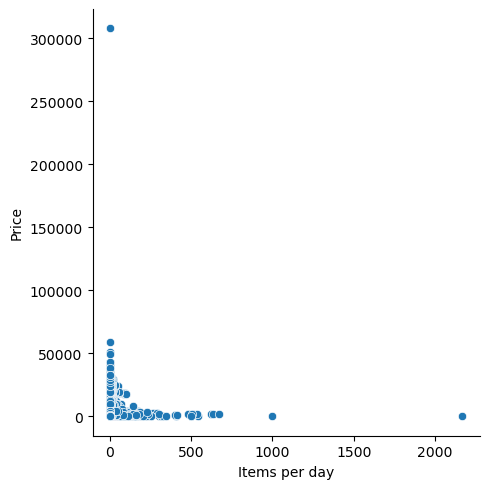

In [11]:
# Scatter plot of stick to visualize the correlation between prices and quantities of products

sns.relplot(x='item_cnt_day', y='item_price', data=sales_train)
plt.xlabel('Items per day')
plt.ylabel('Price')


Text(-12.805555555555555, 0.5, 'Price')

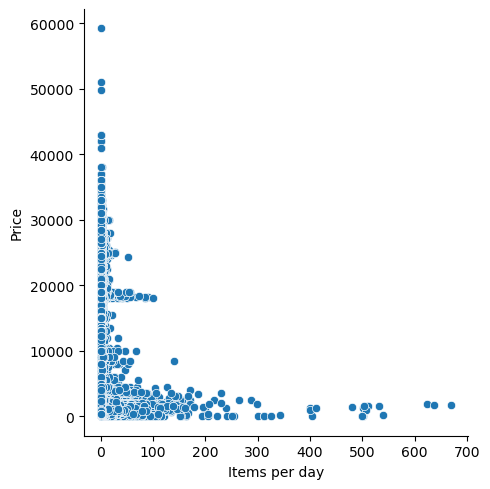

In [12]:
# Visualizing without outliers

# sns.set_palette('colorblind')
sns.relplot(x='item_cnt_day', y='item_price', data=sales_train[(sales_train['item_price'] < 60000 ) & (sales_train['item_cnt_day'] < 1000)])
plt.xlabel('Items per day')
plt.ylabel('Price')

- The quantity of products sold increases as the prices of the items decrease. 

Text(0, 0.5, 'Items per day')

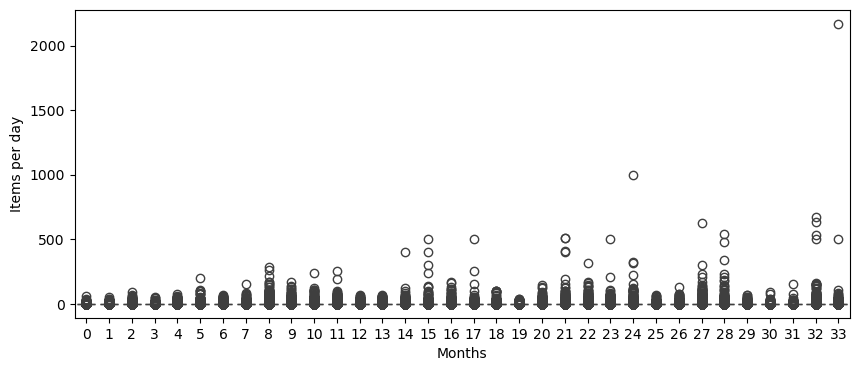

In [13]:
# Viewing the quantity of products sold over the months

plt.figure(figsize=(10,4))
sns.boxplot(data=sales_train, x='date_block_num', y='item_cnt_day')
plt.xlabel('Months')
plt.ylabel('Items per day')

In [14]:
# Calculate 95th to 100th percentile of quantity of items sold

percentiles = range(95, 101)
item_counts = sales_train['item_cnt_day'].values
for p in percentiles:
    value = np.percentile(item_counts, p)
    print(f"Number of items for {p}° percentil value: {value}")

Number of items for 95° percentil value: 2.0
Number of items for 96° percentil value: 2.0
Number of items for 97° percentil value: 3.0
Number of items for 98° percentil value: 3.0
Number of items for 99° percentil value: 5.0
Number of items for 100° percentil value: 2169.0


- Only 1% of items were sold in more than 6 units in one purchase
- In particular, there is only one sale with more than 2000 units of an item

Text(0, 0.5, 'Items per day')

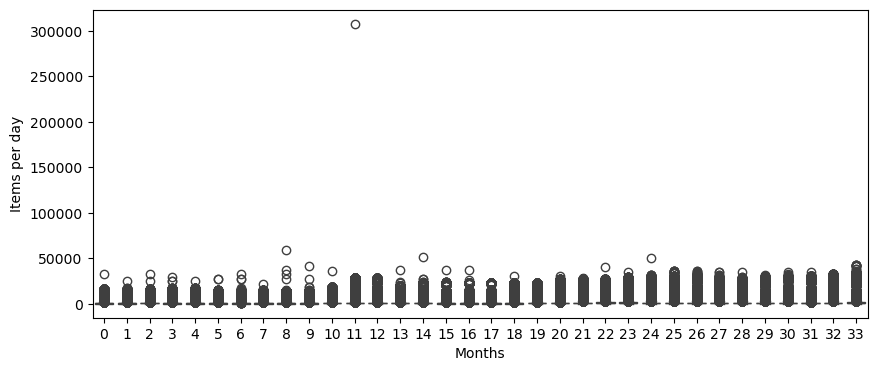

In [15]:
# Viewing the price of items sold over the months

plt.figure(figsize=(10,4))
sns.boxplot(data=sales_train, x='date_block_num', y='item_price')
plt.xlabel('Months')
plt.ylabel('Items per day')

In [16]:
# Calculate 95th to 100th percentile of item prices

percentiles = range(95, 101)
item_counts = sales_train['item_price'].values
for p in percentiles:
    value = np.percentile(item_counts, p)
    print(f"Number of items for {p}° percentil value: {value}")

Number of items for 95° percentil value: 2690.0
Number of items for 96° percentil value: 2999.0
Number of items for 97° percentil value: 3190.0
Number of items for 98° percentil value: 3590.0
Number of items for 99° percentil value: 5999.0
Number of items for 100° percentil value: 307980.0


- Only 1% of items were sold at a price higher than 6000.0
- Outliers: there is a sale with a price higher than 300000.0

Text(0, 0.5, 'Items per day')

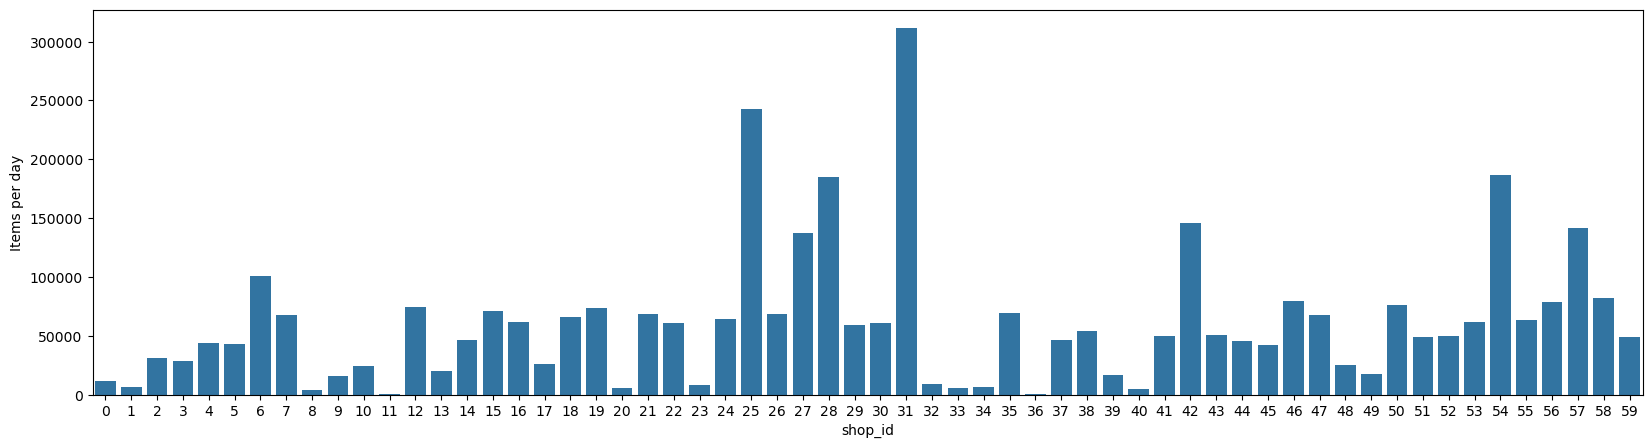

In [18]:
# Visualizing grouped data
# Grouping by shops
# Bar chart between quantities sold and stores

plt.rcParams["figure.figsize"] = [20, 5]
group_shops = sales_train.groupby(['shop_id'])['item_cnt_day'].sum().reset_index()
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shops)
plt.xlabel('shop_id')
plt.ylabel('Items per day')

Text(-21.680555555555557, 0.5, 'Items per day')

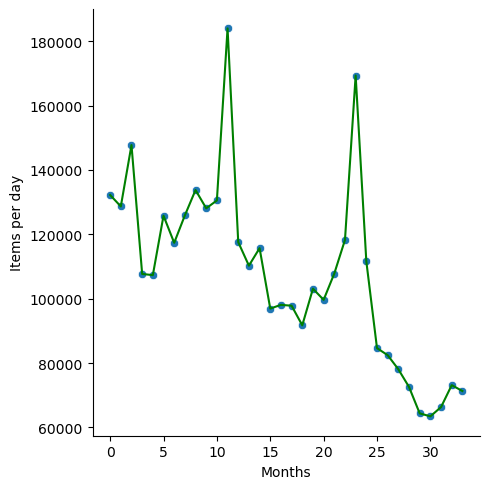

In [19]:
# Visualization of grouped data
# Grouping by months
# Scatter plot between months and quantity of products sold
# Checking if there is any correlation and seasonality between the two variables.

group_shops = sales_train.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
sns.relplot(x='date_block_num', y='item_cnt_day', data=group_shops)
sns.lineplot(data=group_shops, x='date_block_num', y='item_cnt_day', color='green', estimator=None)
plt.xlabel('Months')
plt.ylabel('Items per day')

- There is a negative and seasonal correlation between the quantities of items sold and time (months)

## 1.3. Outlier Detection and Treatment

In [20]:
# Outlier treatment
# Previously extracted insights:
# - Only 1% of items were sold with a price higher than 6000.0
# - Only 1% of items were sold in more than 5 units in a purchase
# Removing outliers: price higher than 6000 and quantity of items higher than 1000

sales_train = sales_train[(sales_train['item_price'] < 60000 ) & (sales_train['item_cnt_day'] < 1000)]

## 1.4. Feature Selection and Feature Engineering

### Adding features for each month

In [21]:
# Joining the tables 'itens.csv' and 'sales_train.csv'
# Objective: include the item category ('item_category_id') as a feature

df_train = sales_train.join(itens, on='item_id', rsuffix='_').drop(['item_id_','item_name'], axis=1)

In [22]:
# Adding relevant features
# Creating a copy of the df_train DataFrame
# The dataframe 'df_train_mensal' will be the new database used after grouping by month

df_train_mensal = df_train.loc[:, ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']].copy()

# Adding a new column 'sales_proceeds' being like the product of item price and quantity sold
df_train_mensal['sales_proceeds'] = df_train_mensal.eval('item_price * item_cnt_day')

# Grouping data to add more features
# Added:
# - The monthly sum of quantities per store and per item
# - The monthly average of quantities per store and per item
# - The monthly average of item prices
df_train_mensal = df_train_mensal.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
df_train_mensal = df_train_mensal.agg({ 'item_cnt_day':['sum', 'mean'],'item_price':['mean'], 'sales_proceeds':['sum']})

# We define new names for the created columns
df_train_mensal.columns = ['date_block_num', 
                           'shop_id', 
                           'item_category_id', 
                           'item_id', 
                           'item_cnt_month_sum', 
                           'item_cnt_month_mean', 
                           'item_price_month_mean', 
                           'sales_proceeds_month_sum']

df_train_mensal

,date_block_num,shop_id,item_category_id,item_id,item_cnt_month_sum,item_cnt_month_mean,item_price_month_mean,sales_proceeds_month_sum
0,0,0,2,5572,10.0,1.666667,1322.00,13220.0
1,0,0,2,5573,1.0,1.000000,560.00,560.0
2,0,0,2,5575,4.0,1.333333,806.00,3224.0
3,0,0,2,5576,5.0,1.000000,2231.00,11155.0
4,0,0,2,5609,1.0,1.000000,2381.00,2381.0
...,...,...,...,...,...,...,...,...
1609117,33,59,75,5383,1.0,1.000000,4390.00,4390.0
1609118,33,59,79,17717,13.0,1.300000,802.55,11335.0
1609119,33,59,83,22087,6.0,2.000000,119.00,714.0
1609120,33,59,83,22088,2.0,1.000000,119.00,238.0


In [23]:
# Creating a dataset considering all possible combinations between month, store and item

# Creating a list with all combinations of ['shop_id','item_id']
shop_ids = sales_test['shop_id'].unique()
item_ids = sales_test['item_id'].unique()
list_combinations= [(i, shop, item) for i in range(34) for shop in shop_ids for item in item_ids]

# We define a new database for all combinations
df_combinations = pd.DataFrame(list_combinations, columns=['date_block_num', 'shop_id', 'item_id'])

# Adding month 34 for testing in the future
sales_test['date_block_num'] = 34

# Converted the columns ['date_block_num', 'shop_id', 'item_id'] to more memory-efficient integer data types
sales_test['date_block_num'] = sales_test['date_block_num'].astype(np.int8)
sales_test['shop_id'] = sales_test['shop_id'].astype(np.int8)
sales_test['item_id'] = sales_test['item_id'].astype(np.int16)

# Concatenate the data from 'sales test' with 'df combinations' to have a compact dataframe with all possible combinations
df_combinations = pd.concat([df_combinations, sales_test.drop(columns=['ID'])], ignore_index=True)
df_combinations.fillna(0, inplace=True)

In [24]:
# We should mix the set 'df_combinations' with the full training set 'df_train_mensal' and fill missing records with 0
df_train_mensal = pd.merge(df_combinations, df_train_mensal, on=['date_block_num','shop_id','item_id'], how='left')
df_train_mensal.fillna(0, inplace=True)

# Updating the columns to add the category id item back to test block 34
df_train_mensal = df_train_mensal.drop(['item_category_id'], axis=1).join(itens, on='item_id', rsuffix='_').drop(['item_id_','item_name'], axis=1)


In [25]:
# In this block we add new features calculated from the columns of the training data 'df_train_mensal'
# These features represent data from the month 'date_block_num'

# We reorganized the coluns of the dataframe
df_train_mensal = df_train_mensal[['date_block_num', 
                                   'shop_id', 
                                   'item_category_id', 
                                   'item_id', 
                                   'sales_proceeds_month_sum', 
                                   'item_cnt_month_sum', 
                                   'item_cnt_month_mean',
                                   'item_price_month_mean']]

# We limit values ​​in the 'item_cnt_month_sum' column
df_train_mensal['item_cnt_month_sum'] = df_train_mensal['item_cnt_month_sum'].fillna(0)

# Extracting features based on time (month).
# We consider months from 1 to 12
df_train_mensal['month'] = (df_train_mensal['date_block_num'] + 1) % 12
df_train_mensal['month'] = df_train_mensal['month'].replace(0, 12)

# Adding the 'date_block_shop_mean' feature
# 'date_block_shop_mean' is the mean of 'item_cnt_month_sum' grouped by 'date_block_num' and 'shop_id'
date_block_shop_mean = df_train_mensal.groupby(['date_block_num', 'shop_id'])['item_cnt_month_sum'].mean().reset_index()
date_block_shop_mean.rename(columns={'item_cnt_month_sum': 'date_block_shop_mean'}, inplace=True)
df_train_mensal = pd.merge(df_train_mensal, date_block_shop_mean, on=['date_block_num', 'shop_id'], how='left')

# Adding the 'date_block_item_mean' feature
# 'date_block_item_mean' is the mean of 'item_cnt_month_sum' grouped by 'date_block_num' and 'item_id'
date_block_item_mean = df_train_mensal.groupby(['date_block_num', 'item_id'])['item_cnt_month_sum'].mean().reset_index()
date_block_item_mean.rename(columns={'item_cnt_month_sum': 'date_block_item_mean'}, inplace=True)
df_train_mensal = pd.merge(df_train_mensal, date_block_item_mean, on=['date_block_num', 'item_id'], how='left')

# Adding the 'date_block_category_mean' feature
# 'date_block_category_mean' is the mean of item_cnt_month_sum grouped by date_block_num and item_category_id
date_block_category_mean = df_train_mensal.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_sum'].mean().reset_index()
date_block_category_mean.rename(columns={'item_cnt_month_sum': 'date_block_category_mean'}, inplace=True)
df_train_mensal = pd.merge(df_train_mensal, date_block_category_mean, on=['date_block_num', 'item_category_id'], how='left')

# Filling missing values ​​with 0
df_train_mensal.fillna(0, inplace=True)

### Adding Lag Features

In [26]:
# In this block we define a function that calculates the 'lag features' of the past of each month of the dataset
# Justification:
# - Lag features help the model to capture patterns and trends over time, improving the accuracy of predictions.
# - It is important to take this approach to implement a regression model
# We consider the Dataset 'df_train_mensal' as a time series of monthly period.
# We consider the past of 3 previous months for each 'date_block_num' of the dataset.


def create_lag_features(df, lags, cols):
    """
    Função que calcula os valores de lag features passados.
    """
    for col in cols:
        for lag in range(1, lags + 1):
            lag_col_name = f"{col}_lag_{lag}"
            df[lag_col_name] = df.groupby(['shop_id', 'item_id'])[col].shift(lag)
    return df


# We added lag features for 3 periods and filled missing records with 0
df_train_mensal = create_lag_features(df_train_mensal, 3, ['item_cnt_month_sum',
                                                           'sales_proceeds_month_sum',
                                                           'item_cnt_month_mean',
                                                           'item_price_month_mean', 
                                                           'date_block_shop_mean',
                                                           'date_block_item_mean',
                                                           'date_block_category_mean']) 
df_train_mensal = df_train_mensal.fillna(0)


# Adding statistical metrics of the new 'lag features' in the dataset
# List of lag features columns
lag_cols = ['item_cnt_month_sum_lag_1', 'item_cnt_month_sum_lag_2', 'item_cnt_month_sum_lag_3']

# Adding the average
df_train_mensal['lag_mean'] = df_train_mensal[lag_cols].mean(skipna=True, axis=1)

# Adding the standard deviation
df_train_mensal['lag_std'] = df_train_mensal[lag_cols].std(skipna=True, axis=1) 

# Adding the minimum value
df_train_mensal['lag_min'] = df_train_mensal[lag_cols].min(skipna=True, axis=1) 

# Adding the maximum value

df_train_mensal['lag_max'] = df_train_mensal[lag_cols].max(skipna=True, axis=1) 

### Data preprocessing and preparation

In [27]:
# Excluding features related to monthly data from the present at the time of each record
df_processed_month = df_train_mensal.drop(['item_price_month_mean',
                                           'sales_proceeds_month_sum',
                                           'item_cnt_month_mean', 
                                           'date_block_shop_mean',
                                           'date_block_item_mean',
                                           'date_block_category_mean'], axis=1)

# Applying one label encoding to categorical features
# We use the 'LabelEncoder' class from the 'sklearn' library
# We apply the transformation to the 'item_category_id' and 'month' columns

colunas_encode = ['item_category_id', 'month']
label_encoders = {}
for column in colunas_encode:
    label_encoders[column] = LabelEncoder()
    df_processed_month[column + '_encoded'] = label_encoders[column].fit_transform(df_processed_month[column])
df_processed_month = df_processed_month.drop(['item_category_id', 'month'], axis=1)

# Filtering the data for the training and validation set
df_processed = df_processed_month[(df_processed_month['date_block_num'] < 34) & (df_processed_month['date_block_num'] > 2)]


## 1.5. Regression Model

### Performance Evaluation Using Time Series Split Cross-Validation

In [28]:
# Since the data is structured and some features are categorical,
# we chose models based on decision trees.
# We used the XGboost model due to its high performance, 
# both in terms of execution time and its correctness.
# In addition We use Time Series Split Cross-Validation for our problem
# We will use the last 10 months as the folds

# Identify unique time points
unique_times = df_processed['date_block_num'].unique()


# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=30)

# Best values according a hyperparameter search: 
# {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 
# 'n_estimators': 200, 'subsample': 0.8}

model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=200, 
                         learning_rate=0.01, 
                         max_depth=7,
                         colsample_bytree=0.8, 
                         subsample=0.8,
                         random_state=42)

mse_values = []
for train_index, val_index in tscv.split(unique_times):
    train_times = unique_times[train_index]
    val_times = unique_times[val_index]
    train_df = df_processed[df_processed['date_block_num'].isin(train_times)]
    val_df = df_processed[df_processed['date_block_num'].isin(val_times)]
    X_train = train_df.drop(['item_cnt_month_sum'], axis=1)
    y_train = train_df['item_cnt_month_sum']
    X_val = val_df.drop(['item_cnt_month_sum'], axis=1)
    y_val = val_df['item_cnt_month_sum']

    # Predict using the best model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Calculate MSE for the current split
    mse = mean_squared_error(y_val, y_pred)
    mse_values.append(mse)

# Calculate average RMSE across all splits
rmse_values = [np.sqrt(i) for i in mse_values]
print("RMSE values:", rmse_values)
average_rmse = sum(rmse_values) / len(rmse_values)
print("Average RMSE:", average_rmse)

# Convert the list into a DataFrame and save it to a CSV file
df_results = pd.DataFrame(rmse_values, columns=['RMSE_xgb'])
df_results.to_csv('results/rmse_values_xgb.csv', index=False)


RMSE values: [1.902926081798034, 3.3650864201471204, 1.4237254661702428, 1.4079038450022447, 3.330480091426947, 2.0392841906651924, 2.212176923622961, 3.024843925108414, 2.039707795289615, 1.5165210505402873, 1.9883528032905087, 1.1549749245153353, 1.5925099229035964, 1.6341981857557444, 1.234044306710909, 1.4503424465245947, 1.4929432638201212, 1.3704499767449119, 2.791596326904105, 3.0009761656456178, 1.545378910414506, 2.1855371174605587, 1.4563881056441688, 3.831922981835259, 3.1798838437548422, 1.3344850339983445, 1.1571384096365225, 1.0643871635051434, 1.4614639153304085, 1.7802809899538912]
Average RMSE: 1.9656636861373387


### Avaliação de Desempenho

Text(0, 0.5, 'RMSE')

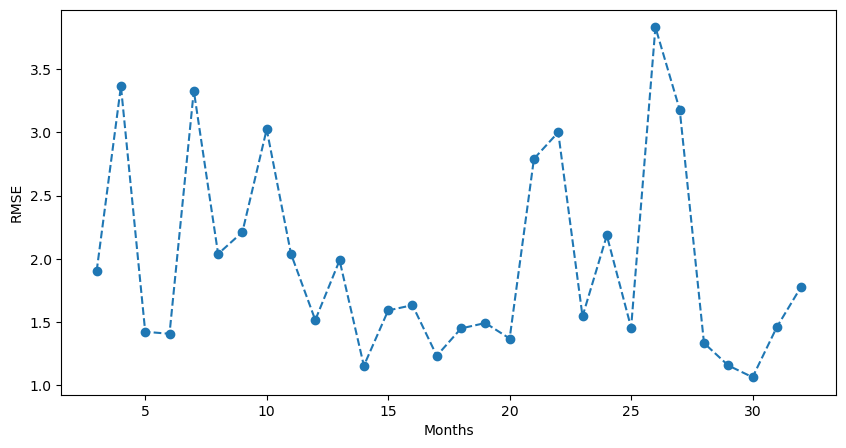

In [29]:
# Visualizing model performance over time
# We will plot the RMSE values ​​for each month

with open('results/rmse_values_xgb.csv', 'r') as f:
    results = f.read().split('\n')
    # Skip the first line (header) and the last line
    results = results[1:-1]
    results = [float(r) for r in results]
    

plt.figure(figsize=(10, 5))
meses = range(3, 33)
plt.plot(meses, results, linestyle='dashed', marker='o')
plt.xlabel('Months')
plt.ylabel('RMSE')


### Interpretation of Results

- There is seasonality in the model results between months 24 (January 2015) and 30 (July 2015)
- We note that there is no trend in consistent error reduction over time.


### Model Persistence

In [30]:
# Creating the definitive model to be used in a production environment
# The model will be used to make inferences through a request in a production environment
# It is necessary to have the database to perform the mapping of the features that will be used in the model

# Filtering the data for the training set
X_train = df_processed_month[(df_processed_month['date_block_num'] < 34) & 
                             (df_processed_month['date_block_num'] > 2)].drop(['item_cnt_month_sum'], axis=1)
y_train = df_processed_month['item_cnt_month_sum'][(df_processed_month['date_block_num'] < 34) & 
                                                   (df_processed_month['date_block_num'] > 2)]

# Filtering the data for the test set
X_test = df_processed_month[df_processed_month['date_block_num'] == 34].drop(['item_cnt_month_sum'], axis=1)

# XGBoost model
model.fit(X_train, y_train)

# Model persistence for use in a prediction endpoint
with open('microservices/application/models/model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Model persistence for use in a prediction endpoint
with open('microservices/website/models/model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Saving the test features Dataframe in .csv for use in a prediction endpoint
X_test.to_csv('microservices/etl_simulator/database/features_dataset.csv', index=False)
